# Вариант 2, оператор 2

# Постановка задачи
Реализовать программно действие псевдообратного оператора $A^-$, воспользовавшись тем, что
$$
A^- y = \lim_{\omega \to +0} \arg\min_{x} \left( \|Ax - y \|^2 - \omega \| x \|^2 \right)
$$

# Анализ задачи
Схема интегрирующей RL-цепи:
<center><img src=https://i.postimg.cc/YSqg1JWq/RL.png width="300"></center>
Для данной цепи можно записать следующее уравнение:
$$
U_{вх} = L \frac{dI}{dt} + IR
$$
где $U_{вх}$ - входное напряжение, $U_{вых}$ - выходное напряжение, $I$ - ток в цепи, $R$ - сопротивление резистора, $L$ - индуктивность.

Учитывая, что $ IR = U_{вых} $, получаем следующее дифференциальное уравнение относительно $U_{вых}$:
$$
\frac{dU_{вых}}{dt} = \frac{1}{\tau} \left( U_{вх} - U_{вых} \right)
$$
где $\tau = \frac{L}{R}$ - время релаксации RL-цепи.

Общее решение данного дифференциального уравнения имеет вид:
$$
U_{вых}(t) = \frac{1}{\tau} \int_{-\infty}^{t} U_{вх}(z) e^{- \frac{(z - t)}{\tau}} dz
$$ 

Пусть входное напряжение $U_{вх}$ подали в момент времени $t = 0$. Тогда окончательный вид искомого выражения:
$$
U_{вых}(t) = \frac{1}{\tau} \int_{0}^{t} U_{вх}(z) e^{- \frac{(z - t)}{\tau}} dz
$$ 

Таким образом, оператор интегрирующей RL-цепи представляет собой правило, сопоставляющее некоторому входному напряжению $U_{вх}$ выходное напряжение $U_{вых}$:
$$
U_{вых} = A[U_{вх}] = \frac{1}{\tau} \int_{0}^{t} U_{вх}(z) e^{- \frac{(z - t)}{\tau}} dz
$$

# Численное решение

Введем на рассматриваевом отрезке времени $[0, T]$ равномерную сетку:
$$
w_{t} = \{ t_n = n \Delta t , n = \overline{0, N} \}
$$
где $N$ - количество узлов сетки, $\Delta t$ - шаг по времени $t$.

Используя формулу метода прямоугольников, получим приближенное значение интеграла для $U_{вых}$:
$$
U_{вых} = \frac{1}{\tau} \int_{0}^{t} U_{вх}(z) e^{- \frac{(z - t)}{\tau}} dz \approx \frac{1}{\tau} \sum_{i=0}^{n} U_{вх_{i}} e^{- \frac{(t_i - t_n)}{\tau}} \Delta t = \sum_{i=0}^{n} \lambda U_{вх_{i}} e^{-(t_i - t_n) \lambda}
$$
где $\lambda = \frac{\Delta t}{\tau}$, a $U_{вх_{i}} = U_{вх} \vert_{t=i \Delta t}$

Таким образом, действие оператора на вышеописанной сетке будет иметь вид:
$$
A[U_{вх}] \vert_{t=t_{i}} = A[U_{вх}]_i = \sum_{i=0}^{n} \lambda U_{вх_{i}} e^{-(t_i - t_n) \lambda} \Delta t
$$

Для удобства, переобозначим:
$$
U_{вх} = x
$$

Тогда, с учетом введенного обозначения, квадраты норм:
$$
\displaystyle \| Ax - y \|^2 = \int_{0}^{T} \left( Ax(t) - y(t) \right)^2 dt \approx \sum_{j=0}^{N} \left( Ax_j - y_j \right)^2 \Delta t \\
\displaystyle \| x \|^2 = \int_{0}^{T} x(t)^2 dt \approx \sum_{j=0}^{N} x_{j}^{2} \Delta t
$$

В соответствии с формулой для псевдообратного оператора получим окончательный вид функционала:
$$
\Phi(x_0,...,x_N) = \sum_{j=0}^{N} \left[ \left( \sum_{i=0}^{j} \lambda U_{вх_{i}} e^{-(t_i - t_n) \lambda} - y_j \right)^2 + \omega x_{j}^2 \right] 
$$

Задача состоит в том, чтобы минимизировать функционал $\Phi$ относительно $x_i, i = \overline{0,N}$. Решать данную задачу будем градиентными методами с помощью библиотеки SciPy.

Также, учитывая то, что оператор $A$ линеен, выпишем матрицу $\tilde{A}$, воспользовавшись ранее выписанной формулой численной аппроксимации оператора $A$:
$$
\tilde{A}_{(N+1) \times (N+1)} = \begin{pmatrix} 
0& 0& 0& \ldots& 0 \\ \gamma e^{\gamma}& \gamma& 0& \ldots& 0 \\ \gamma e^{2 \gamma}& \gamma e^{\gamma}& \gamma& \ldots& 0 \\ \vdots& \vdots& \vdots& \ddots& \vdots \\ \gamma e^{N \gamma}& \gamma e^{(N-1) \gamma}& \gamma e^{(N-2) \gamma}& \ldots& \gamma \end{pmatrix} = \begin{equation*} \begin{cases} \gamma e^{(i - j)\gamma}, 0 < j \leq i \\ 0, i < j \\ 0, i=j=0 \end{cases} \end{equation*}
$$

# Код программы и построение графиков

In [123]:
import math
import numpy as np
import scipy.optimize
from numpy import linalg
import matplotlib.pyplot as plt

In [124]:
def A(x):
    return [ np.sum( [λ * math.exp((j - i) * λ) * x[i] for i in range(j + 1)] ) for j in range(len(x)) ]

def Fun(x, ω):
    A_x = A(x)
    return np.sum([ ((A_x[j] - y[j])**2 + ω * x[j]**2) for j in range(len(x)) ])

def A_matrix():
    matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if (i == j and i > 0):
                matrix[i][j] = λ
            elif (i > j):
                matrix[i][j] = λ * math.exp((i - j) * λ)
    return matrix

In [169]:
τ = 100
ω = 1E-6
T = 10
N = 80

y = np.ones(N)
for i in range(N):
    if i > int(N/2) - 1:
        y[i] = 0

grid_t, Δt = np.linspace(start = 0, 
                         stop = T, 
                         num = N, 
                         endpoint = False,
                         retstep = True)
λ = Δt/τ
        
A_M = A_matrix()
A_y_mat = linalg.pinv(A_M).dot(y)

x0 = np.zeros(N)
A_y = scipy.optimize.minimize(fun = Fun, 
                              x0 = x0, 
                              method = 'CG',
                              args = ω,
                              options = {'disp': True})

Optimization terminated successfully.
         Current function value: 0.783352
         Iterations: 115
         Function evaluations: 53217
         Gradient evaluations: 657


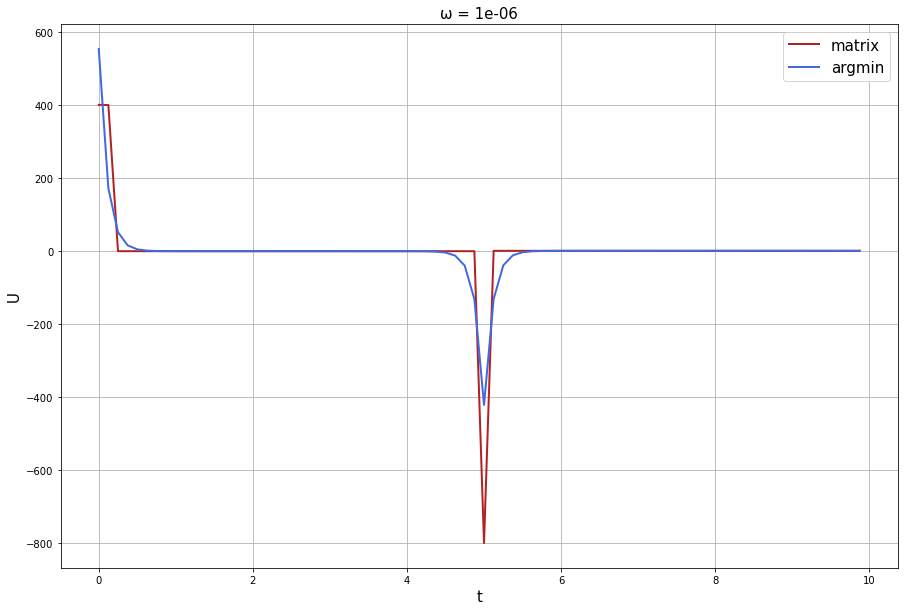

In [170]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)

ax.plot(grid_t, A_y_mat, color='firebrick', label='matrix', linewidth=2, markersize=12)
ax.plot(grid_t, A_y.x, color='royalblue', label='argmin', linewidth=2, markersize=12)
plt.title('ω = ' + str(ω), fontsize=15)
plt.ylabel('U', fontsize=15)
plt.xlabel('t', fontsize=15)
plt.grid()

ax.legend(fontsize = 15)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


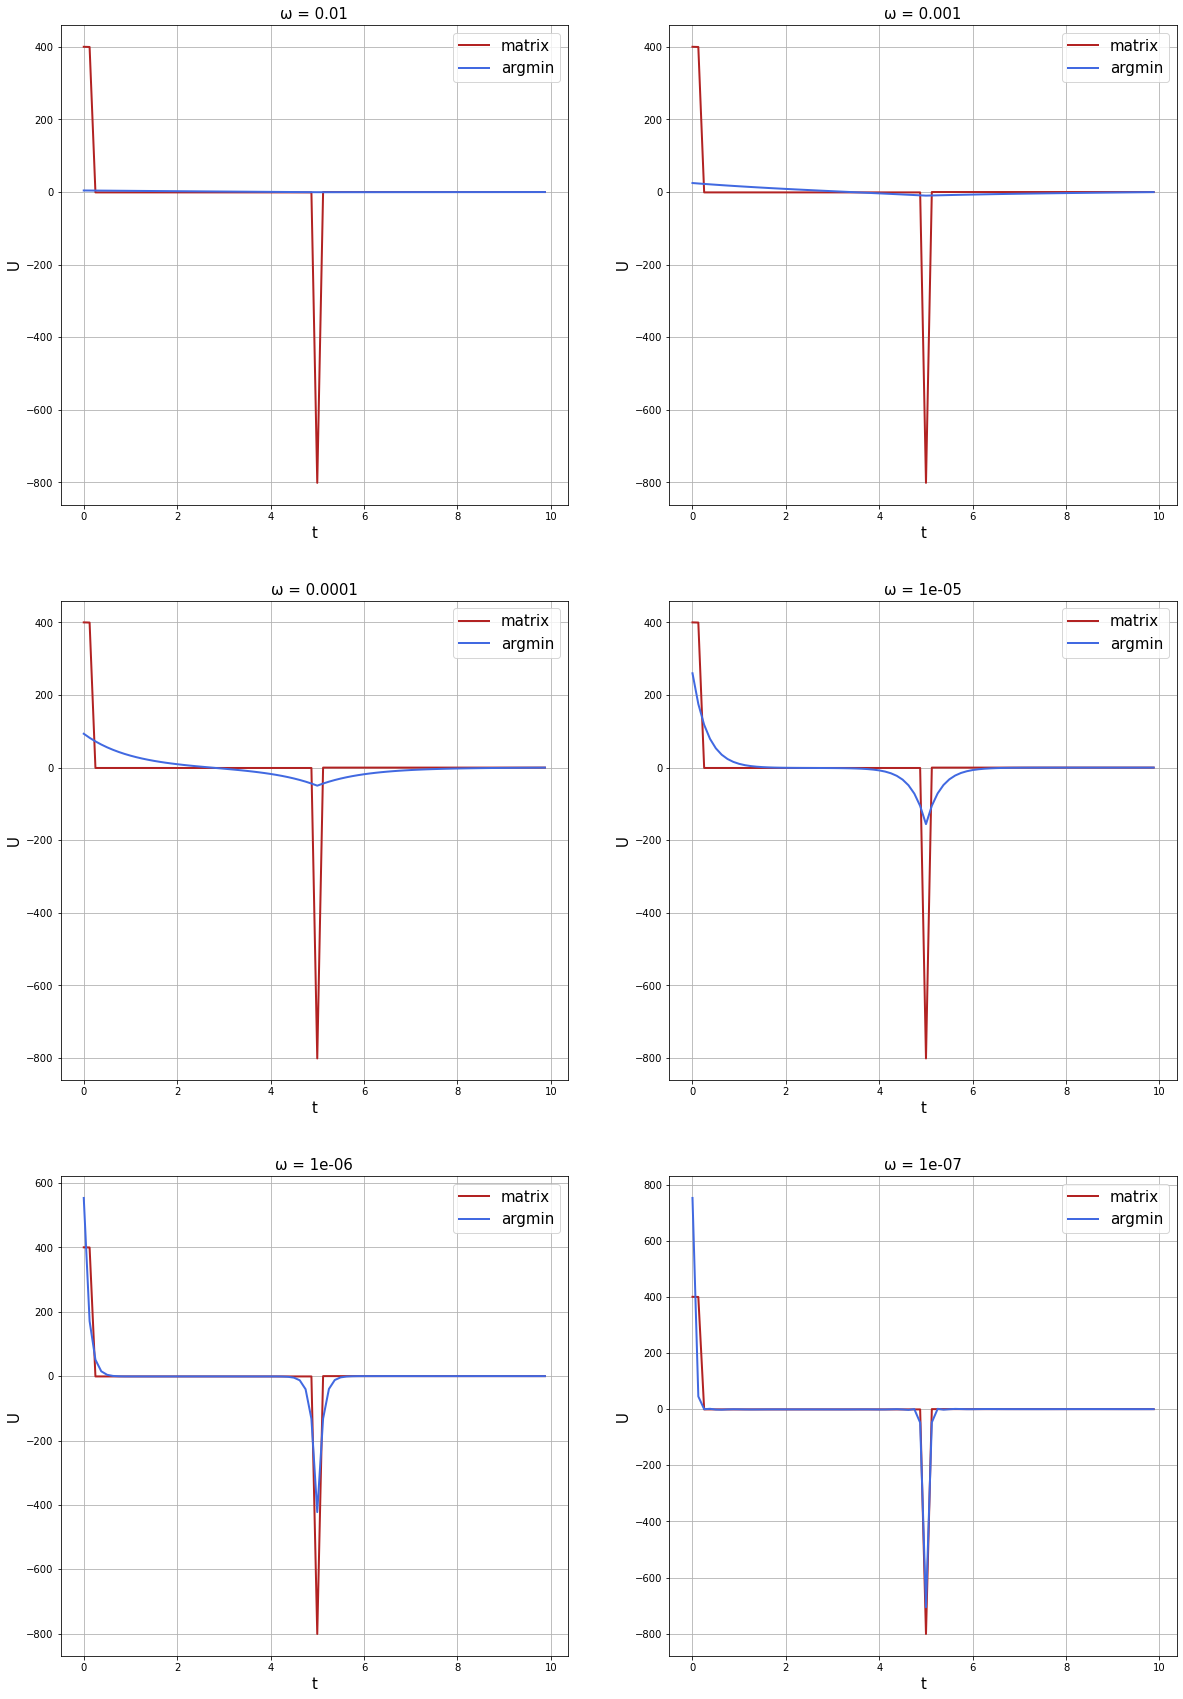

In [168]:
omegas = [1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
τ = 100
T = 10
N = 80

y = np.ones(N)
for i in range(N):
    if i > int(N/2) - 1:
        y[i] = 0

        
grid_t, Δt = np.linspace(start = 0, 
                         stop = T, 
                         num = N, 
                         endpoint = False,
                         retstep = True)
λ = Δt/τ


A_M = A_matrix()
A_y_mat = linalg.pinv(A_M).dot(y)


x0 = np.zeros(N)

fig = plt.figure(figsize=(20,30))

for it, ω in enumerate(omegas, 1):
    print(f"Iteration: {it}")

    A_y = scipy.optimize.minimize(fun = Fun, 
                                  x0 = x0, 
                                  method = 'CG',
                                  args = ω)
    
    ax = fig.add_subplot(3, 2, it)
    ax.plot(grid_t, A_y_mat, color='firebrick', label='matrix', linewidth=2, markersize=12)
    ax.plot(grid_t, A_y.x, color='royalblue', label='argmin', linewidth=2, markersize=12)
    plt.title('ω = ' + str(ω), fontsize=15)
    plt.ylabel('U', fontsize=15)
    plt.xlabel('t', fontsize=15)
    plt.grid()
    ax.legend(fontsize=15)